# SemEval 2020 Task 12: OffensEval2

### Installing packages

In [1]:
!pip install unidecode

     |████████████████████████████████| 245kB 2.7MB/s 


In [2]:
!pip install word2number

  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=545dbddd5efbfa1a709387fd9a231fb82ce9379636d9426ae53aee65739d0b80
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


In [3]:
!pip install contractions

     |████████████████████████████████| 317kB 4.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81699 sha256=7b36899fe1bb37716f4a3b2708f7bf417f755431594cbc8f1e72b19911a3b9c0
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [4]:
!pip install wordsegment

     |████████████████████████████████| 4.8MB 2.8MB/s 


## Data preprocessing

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
from word2number import w2n
import contractions
import gensim.downloader as api
import re
import wordsegment

wordsegment.load()

In [6]:
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
print(training_dataset.head())
test_tweets_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/testset-levela.tsv'
test_tweets = pd.read_csv(test_tweets_url, delimiter='\t')
print(test_tweets.head())
test_labels_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/labels-levela.csv'
test_labels = pd.read_csv(test_labels_url, delimiter=',', header=None, names=["id", "label"])
print(test_labels.head())
test_dataset = test_tweets.set_index("id").join(test_labels.set_index("id"))
test_dataset.head()

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]
      id                                              tweet
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1  27014  #ConstitutionDay is revered by Conservatives, ...
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3  13876  #Watching #Boomer getting the news that she is...
4  60133  #NoPasaran: Unity demo to oppose the far-right...
      id label
0  15923   OFF
1  27014   NOT
2  30530   NOT
3  13876   NOT
4  60133   OFF


,tweet,label
id,,
15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
13876,#Watching #Boomer getting the news that she is...,NOT
60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


In [0]:
# training_examples, validation_examples = train_test_split(training_dataset, test_size=0.1)

# prepare training examples
training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# prepare validation examples
# validation_examples_A = validation_examples['tweet'][validation_examples['subtask_a'].notnull()]
# validation_examples_B = validation_examples['tweet'][validation_examples['subtask_b'].notnull()]
# validation_examples_C = validation_examples['tweet'][validation_examples['subtask_c'].notnull()]

# prepare test examples and labels
test_examples_A = test_dataset['tweet'][test_dataset['label'].notnull()]
test_labels_A = (test_dataset['label'][test_dataset['label'].notnull()] == 'OFF').astype(int)

# prepare training labels
training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}
training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# prepare validation labels
# validation_labels_A = (validation_examples['subtask_a'][validation_examples['subtask_a'].notnull()] == 'OFF').astype(int)
# validation_labels_B = (validation_examples['subtask_b'][validation_examples['subtask_b'].notnull()] == 'TIN').astype(int)
# validation_labels_C = (validation_examples['subtask_c'][validation_examples['subtask_c'].notnull()]).replace(c_mapping)

training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
    training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A)
training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
    training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B)
training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
    training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C)

training_x = list(training_examples_A)
validation_x = list(validation_examples_A)
training_y = list(training_labels_A)
validation_y = list(validation_labels_A)
test_x = list(test_examples_A)
test_y = list(test_labels_A)

In [8]:
# Preprocessing
# hashtags, normalization, removal of - in words like ex-wife, Emoji substitution

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


# all preprocessing executions
def preprocess_basic(text):
    text = strip_html_tags(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = text.lower()

    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        
        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # convert number words to numeric numbers
        if token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_

        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text


preprocessed_x = [preprocess_basic(example) for example in training_x[0:10]]
print(preprocessed_x[0:10])
print(training_x[0:10])

[['@user', '@user', 'brother', 'think', 'monster', 'url'], ['@user', '@user', 'think', 'great'], ['@user', '@user', 'trump', 'win', 'growth', 'continue', 'crazy', 'liberal', 'thank', 'obama', 'year', 'coarse', 'argument', 'lose', 'leave', 'dispute', 'fact'], ['year', 'ago', 'today', 'cherry', 'oakwood', 'radio', 'hostess', 'go', 'home', 'god', 'url'], ['@user', '@user', 'influential', 'person', 'politic', 'smart', 'left', 'air', 'america', 'work', 'not'], ['@user', 'michael', 'avanetti', 'msp', 'say', 'similar', 'today', 'great', 'tweet', 'away', 'follow'], ['@user', '@user', '@user', '@user', 'anonymous', 'profile', 'pic', 'follower', 'defend', 'trump', 'lot', 'thread', 'no', 'idea', 'prepared', 'not', '+', 'people', 'die', 'pr', 'lack', 'preparedness', 'response', 'damage', 'ice', 'not', 'need', 'm', 'cage', 'child'], ['@user', '@user', 'aim', 'right', 'way', 'whooo', 'whooo'], ['call', 'hotel', 'send', 'shuttle', 'come', 'pick', 'mother', 'sit', '@user', 'terminal', 'airport', 'agen

In [0]:
# Remove redundant @user tokens

def remove_redundant_users(example):
  user_count = 0
  new_example = example[:]
  for i, token in reversed(list(enumerate(example))):
    if token == '@user':
      user_count += 1
      if user_count > 3:
        new_example.pop(i)

    else:
      user_count = 0

  return new_example

new_x = [remove_redundant_users(example) for example in preprocessed_x]

## Class imbalance

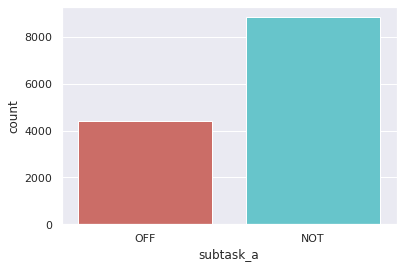

subtask_a
NOT    8840
OFF    4400
Name: id, dtype: int64


In [10]:
#Depict class imbalance for the subtask A
sns.set(font_scale=1.0)
countplt=sns.countplot(x='subtask_a', data=training_dataset, palette ='hls')
plt.show()

print(training_dataset.groupby('subtask_a').count()['id'])

## Preparing embeddings

In [0]:
preprocessed_train = [remove_redundant_users(preprocess_basic(example)) for example in training_x]

In [0]:
preprocessed_valid = [remove_redundant_users(preprocess_basic(example)) for example in validation_x]

In [0]:
preprocessed_test = [remove_redundant_users(preprocess_basic(example)) for example in test_x]

In [0]:
vocab = preprocessed_train + preprocessed_valid + preprocessed_test   # is that correct?

In [15]:
max_lenght = 0
for line in vocab:
    max_lenght = max(max_lenght, len(line))

max_lenght

48

In [0]:
from gensim.models import Word2Vec
word2vec = Word2Vec(vocab, size=100, min_count=2)     # would bigger size be better?

In [17]:
sim_words = word2vec.wv.most_similar('maga')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
for i in sim_words[:10]:
    print(i)

('q', 0.9934275150299072)
('red', 0.9874956011772156)
('wwg1wga', 0.9852309823036194)
('kag', 0.9818654656410217)
('non', 0.9804006814956665)
('cot', 0.9770062565803528)
('walk', 0.9768493175506592)
('trump', 0.9747064113616943)
('awakening', 0.9737950563430786)
('confirm', 0.9712246060371399)


In [19]:
w2v_weights = word2vec.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 7364 - Embedding Dim: 100


## LSTM model

### Preparing data representation suitable for model

In [0]:
def word2idx(word):
    try:
        return word2vec.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def idx2word(token):
    return word2vec.wv.index2word[token]

In [0]:
def word2idx_set(X):
    new_X = []

    for line in X:
        new_line = []
        for w in line:
            new_line.append(word2idx(w))
        new_X.append(new_line)
    
    return new_X

In [22]:
from keras.preprocessing.sequence import pad_sequences

X_train = np.asarray(word2idx_set(preprocessed_train))
X_train = pad_sequences(X_train, maxlen=max_lenght, padding='pre', value=0)

X_valid = np.asarray(word2idx_set(preprocessed_valid))
X_valid = pad_sequences(X_valid, maxlen=max_lenght, padding='pre', value=0)

X_test = np.asarray(word2idx_set(preprocessed_test))
X_test = pad_sequences(X_test, maxlen=max_lenght, padding='pre', value=0)

X_train.shape, X_valid.shape, X_test.shape

Using TensorFlow backend.


((11916, 48), (1324, 48), (860, 48))

### Defining and training model

In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint

In [24]:
from google.colab import drive
drive.mount('/content/drive')
PATH_TO_DIR = '/content/drive/My Drive/STUDIA/SEM 9/pracownia/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Bidirectionl LSTM

In [44]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght,
                    mask_zero=True))

model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 100)           736400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 897,401
Trainable params: 897,401
Non-trainable params: 0
_________________________________________________________________


In [45]:
mc = ModelCheckpoint(PATH_TO_DIR + 'best_bidir.h5',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), verbose=1, callbacks=[mc])

Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 38s 3ms/step - loss: 0.6280 - acc: 0.6677 - val_loss: 0.5818 - val_acc: 0.7032

Epoch 00001: val_loss improved from inf to 0.58182, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir.h5
Epoch 2/5
11916/11916 [==============================] - 36s 3ms/step - loss: 0.4907 - acc: 0.7734 - val_loss: 0.5058 - val_acc: 0.7711

Epoch 00002: val_loss improved from 0.58182 to 0.50576, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_bidir.h5
Epoch 3/5
11916/11916 [==============================] - 36s 3ms/step - loss: 0.3573 - acc: 0.8515 - val_loss: 0.5854 - val_acc: 0.7470

Epoch 00003: val_loss did not improve from 0.50576
Epoch 4/5
11916/11916 [==============================] - 36s 3ms/step - loss: 0.2833 - acc: 0.8858 - val_loss: 0.6982 - val_acc: 0.7440

Epoch 00004: val_loss did not improve from 0.50576
Epoch 5/5
11916/11916 [================

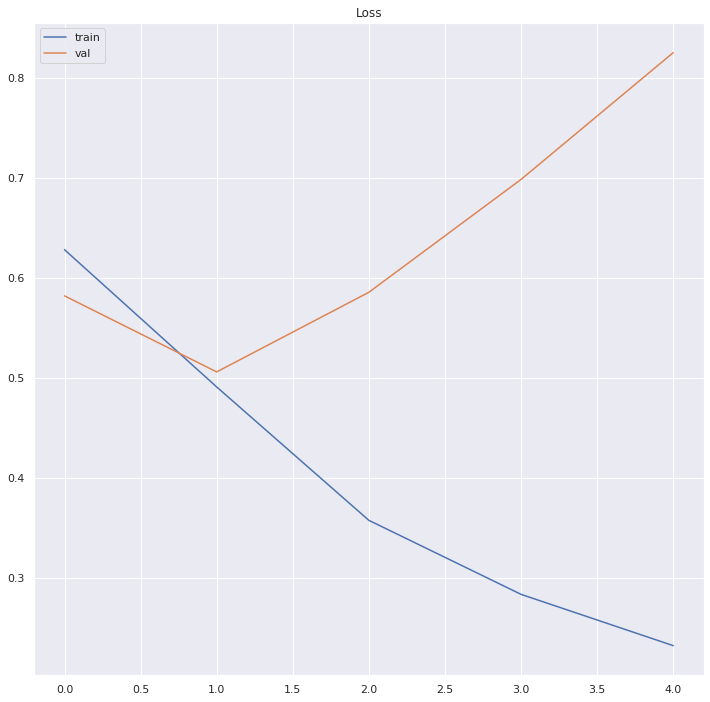

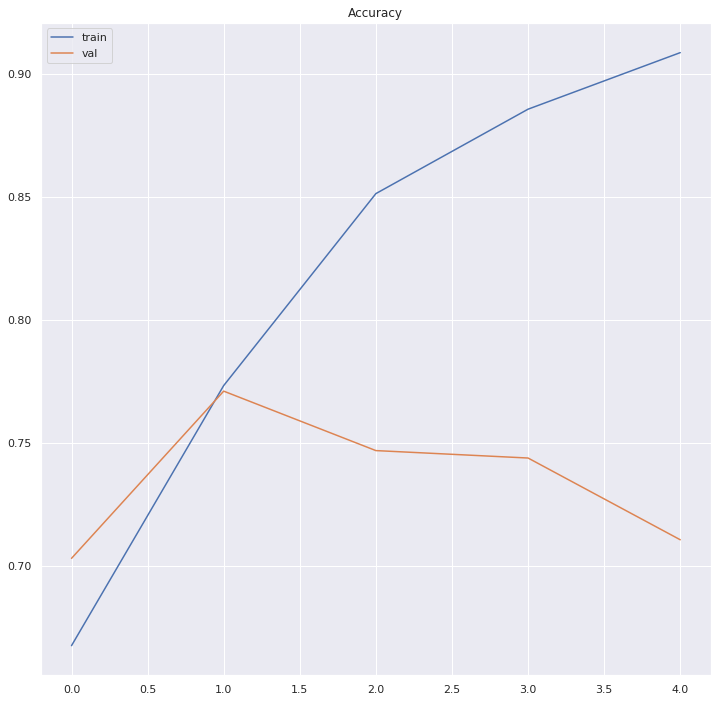

In [50]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 1s 1ms/step


[0.7751507330772489, 0.7406976746958356]

In [0]:
model.save_weights(PATH_TO_DIR + "check_bidir.h5")

In [0]:
model.load_weights(PATH_TO_DIR + 'best_bidir.h5')

In [49]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 1s 1ms/step


[0.4394642321176307, 0.8104651162790698]

### LSTM with recurrent dropout

In [44]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght,
                    mask_zero=True))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 100)           736400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 816,901
Trainable params: 816,901
Non-trainable params: 0
_________________________________________________________________




In [46]:
mc = ModelCheckpoint(PATH_TO_DIR + 'best.h5',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), verbose=1, callbacks=[mc])



Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 24s 2ms/step - loss: 0.6328 - acc: 0.6685 - val_loss: 0.5959 - val_acc: 0.6767

Epoch 00001: val_loss improved from inf to 0.59593, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best.h5
Epoch 2/5
11916/11916 [==============================] - 23s 2ms/step - loss: 0.5102 - acc: 0.7572 - val_loss: 0.5136 - val_acc: 0.7492

Epoch 00002: val_loss improved from 0.59593 to 0.51363, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best.h5
Epoch 3/5
11916/11916 [==============================] - 23s 2ms/step - loss: 0.3832 - acc: 0.8364 - val_loss: 0.5458 - val_acc: 0.7583

Epoch 00003: val_loss did not improve from 0.51363
Epoch 4/5
11916/11916 [==============================] - 23s 2ms/step - loss: 0.3061 - acc: 0.8728 - val_loss: 0.6315 - val_acc: 0.7508

Epoch 00004: val_loss did not improve from 0.51363
Epoch 5/5
11916/11916 [==========================

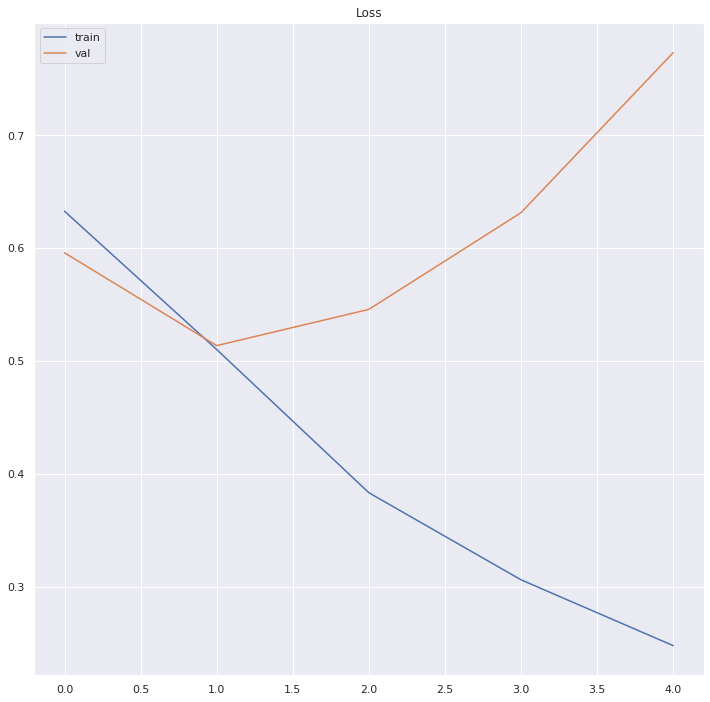

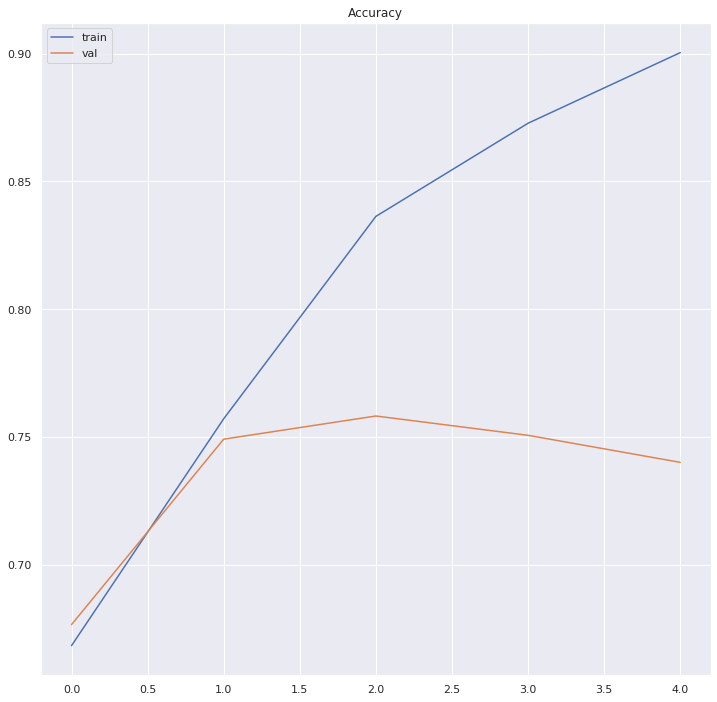

In [47]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.save_weights(PATH_TO_DIR + 'check2.h5')

In [49]:
model.evaluate(X_test, test_y, batch_size=64, verbose=1)

860/860 [==============================] - 1s 710us/step


[0.6473598527353863, 0.7569767450177393]

In [0]:
model.load_weights(PATH_TO_DIR + 'best.h5')

In [51]:
model.evaluate(X_test, test_y, batch_size=64, verbose=1)

860/860 [==============================] - 1s 642us/step


[0.4317082051620927, 0.8104651171107625]

### LSTM with L2 regulatization

In [0]:
from keras.regularizers import l2
from keras.optimizers import Adam

In [26]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght,
                    mask_zero=True))

model.add(LSTM(100))
model.add(Dense(max_lenght, activation='relu', W_regularizer=l2(0.90)))
model.add(Dense(1, activation='sigmoid', W_regularizer=l2(0.1)))
# adam_1 = Adam(lr=0.008)
model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy'])










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(48, activation="relu", kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.


In [27]:
mc = ModelCheckpoint(PATH_TO_DIR + 'best_reg.h5',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), verbose=1, callbacks=[mc])



Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 19s 2ms/step - loss: 19.2941 - acc: 0.6677 - val_loss: 2.7003 - val_acc: 0.6677

Epoch 00001: val_loss improved from inf to 2.70026, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_reg.h5
Epoch 2/5
11916/11916 [==============================] - 18s 2ms/step - loss: 1.1346 - acc: 0.6677 - val_loss: 0.6650 - val_acc: 0.6677

Epoch 00002: val_loss improved from 2.70026 to 0.66495, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_reg.h5
Epoch 3/5
11916/11916 [==============================] - 18s 2ms/step - loss: 0.6310 - acc: 0.6677 - val_loss: 0.6254 - val_acc: 0.6677

Epoch 00003: val_loss improved from 0.66495 to 0.62541, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_reg.h5
Epoch 4/5
11916/11916 [==============================] - 19s 2ms/step - loss: 0.5875 - acc: 0.7120 - val_loss: 0.6150 - val_acc: 0.7545

Epoch 00004

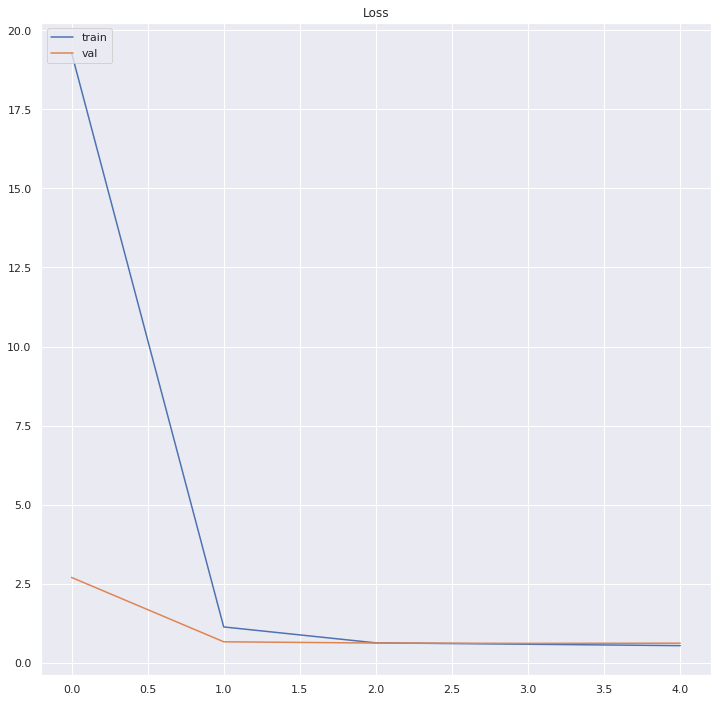

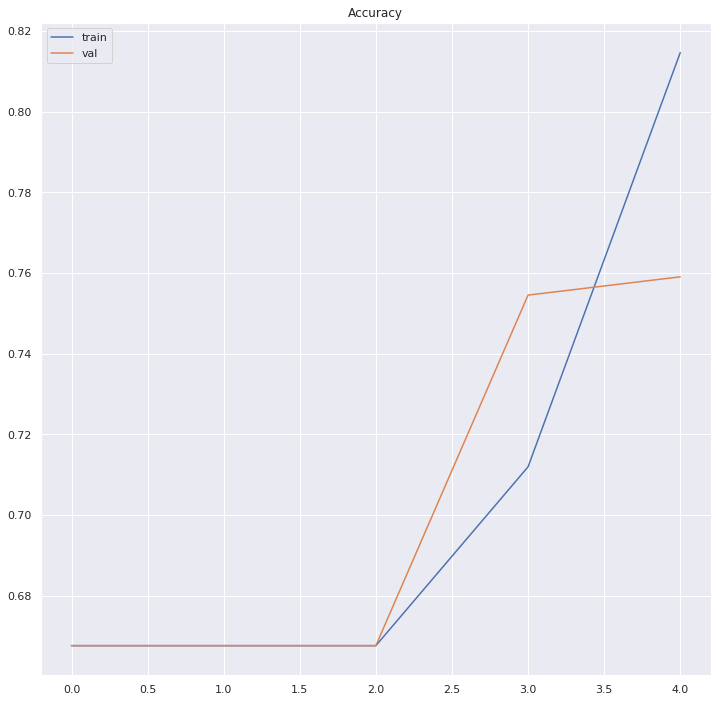

In [28]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 512us/step


[0.5630058126394138, 0.8023255819498106]

In [0]:
model.save_weights(PATH_TO_DIR + 'check_reg.h5')

In [0]:
model.load_weights(PATH_TO_DIR + 'best_reg.h5')

In [32]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 537us/step


[0.5659678345502809, 0.7930232563684153]

### LSTM model with convolution layer

In [53]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=max_lenght))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 100)           736400    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 799,333
Trainable params: 799,333
Non-trainable params: 0
_________________________________________________________________


In [55]:
mc = ModelCheckpoint(PATH_TO_DIR + 'best_conv.h5',
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

history = model.fit(X_train, training_y, epochs=5, batch_size=64,
                    validation_data=(X_valid, validation_y), verbose=1, callbacks=[mc])

Train on 11916 samples, validate on 1324 samples
Epoch 1/5
11916/11916 [==============================] - 10s 798us/step - loss: 0.6285 - acc: 0.6641 - val_loss: 0.6245 - val_acc: 0.6654

Epoch 00001: val_loss improved from inf to 0.62454, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_conv.h5
Epoch 2/5
11916/11916 [==============================] - 8s 673us/step - loss: 0.5145 - acc: 0.7473 - val_loss: 0.5608 - val_acc: 0.7311

Epoch 00002: val_loss improved from 0.62454 to 0.56080, saving model to /content/drive/My Drive/STUDIA/SEM 9/pracownia/best_conv.h5
Epoch 3/5
11916/11916 [==============================] - 8s 671us/step - loss: 0.3558 - acc: 0.8491 - val_loss: 0.5940 - val_acc: 0.7175

Epoch 00003: val_loss did not improve from 0.56080
Epoch 4/5
11916/11916 [==============================] - 8s 668us/step - loss: 0.2581 - acc: 0.8959 - val_loss: 0.7336 - val_acc: 0.7122

Epoch 00004: val_loss did not improve from 0.56080
Epoch 5/5
11916/11916 [=============

In [0]:
model.save_weights(PATH_TO_DIR + 'check_conv.h5')

In [57]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 324us/step


[0.7262845920961957, 0.7476744180501893]

In [0]:
model.load_weights(PATH_TO_DIR + 'best_conv.h5')

In [59]:
model.evaluate(X_test, test_y, batch_size=64)

860/860 [==============================] - 0s 312us/step


[0.4674119846765385, 0.7755813953488372]

## SVM model

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform([" ".join(tweet) for tweet in preprocessed_train])
test_vectors = vectorizer.transform([" ".join(tweet) for tweet in preprocessed_test])

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, training_y)
prediction_linear = classifier_linear.predict(test_vectors)

# results
accuracy = accuracy_score(test_y, prediction_linear, normalize=True, sample_weight=None)

print("Results for SVC(kernel=linear)")
report = classification_report(test_y, prediction_linear, output_dict=True)
print('not offensive: ', report['0'])
print('offensive: ', report['1'])
print('Accuracy:', accuracy)

Results for SVC(kernel=linear)
not offensive:  {'precision': 0.8286516853932584, 'recall': 0.9516129032258065, 'f1-score': 0.8858858858858858, 'support': 620}
offensive:  {'precision': 0.7972972972972973, 'recall': 0.49166666666666664, 'f1-score': 0.6082474226804123, 'support': 240}
Accuracy: 0.8232558139534883


## FastText

In [60]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

--2019-11-20 11:46:02--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/0.2.0 [following]
--2019-11-20 11:46:03--  https://codeload.github.com/facebookresearch/fastText/zip/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [     <=>            ]   4.10M  2.78MB/s    in 1.5s    

2019-11-20 11:46:05 (2.78 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflating: fastText-0.2.0

In [0]:
f = open('train.txt', 'w')
for i, tweet in enumerate(preprocessed_train):
    f.write('__label__' + str(training_y[i]) + " " + " ".join(tweet) + '\n')
f.close()

f = open('test.txt', 'w')
for i, tweet in enumerate(preprocessed_test):
    f.write(" ".join(tweet) + '\n')
f.close()

In [70]:
!./fasttext supervised -input train.txt -output model -dim 2

Read 0M words
Number of words:  13684
Number of labels: 2
Progress: 100.0% words/sec/thread:  661047 lr:  0.000000 loss:  0.454839 ETA:   0h 0m


In [0]:
!./fasttext predict model.bin test.txt > results.txt

In [77]:
predictions = []

with open('results.txt', 'r') as f:
    for line in f.readlines():
        predictions.append(int(line.replace('__label__', '')))

predictions[:10]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 0]

In [78]:
accuracy = accuracy_score(test_y, predictions, normalize=True, sample_weight=None)
print('Accuracy:', accuracy)

Accuracy: 0.8023255813953488


## Notes

In [0]:
'''
Naïve Bayes: a family of probabilistic algorithms that uses Bayes’s Theorem to predict the category of a text.

Linear Regression: a very well-known algorithm in statistics used to predict some value (Y) given a set of features (X).

Support Vector Machines: a non-probabilistic model which uses a representation of text examples as points in a multidimensional space. 
These examples are mapped so that the examples of the different categories (sentiments) belong to distinct regions of that space.. 
Then, new texts are mapped onto that same space and predicted to belong to a category based on which region they fall into.

extremeText/fastText
tfidf+bow-NB

svc_tfidf           0.9656
svc                 0.9562
w2v_tfidf           0.9544
w2v                 0.9510
mult_nb             0.9467
glove_big           0.9274
glove_small         0.9262
glove_small_tfidf   0.9075
glove_big_tfidf     0.9038
mult_nb_tfidf       0.8615
bern_nb             0.7954
bern_nb_tfidf       0.7954

logistic regression -> https://itnext.io/machine-learning-sentiment-analysis-of-movie-reviews-using-logisticregression-62e9622b4532
'''